In [129]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from mvo_utils_v3 import *
from workspace import OptWorkspace

In [130]:
opt_env = OptWorkspace(252, 1, 1, 0, 0.3, universe='fixed-income', etfOnly=True, historicWindow=252*5)
# opt_env = OptWorkspace(252, 0.5, 1, -0.2, 0.2, universe='spy-sectors', etfOnly=True, historicWindow=252*5)
opt_env.refreshPricing = True
opt_env.print_global_vars()

Global Variables
Refresh Pricing: True
Historical Time Window: 1260
Lookback: 252
Rebalance Frequency: W-Sat
Net Exposure: 1
Leverage: 1
Weights: min 0 to max 0.3
Universe: fixed-income



In [131]:
if opt_env.refreshPricing:
    opt_env.refresh_sector_px();
    opt_env.get_pricing('SPY.csv', ['SPY']);

Getting pricing for: fixed-income.csv 2014-11-01
[*********************100%***********************]  9 of 9 downloaded
Getting pricing for: SPY.csv 2014-11-01
[*********************100%***********************]  1 of 1 downloaded


In [132]:
consol_px = opt_env.load_px()
px_spy = opt_env.load_px('SPY.csv')
# calculates optimal gamma
gamma_val, gamma_sr = opt_env.quick_gamma(opt_env.gammaVals, consol_px)
gamma_val, gamma_sr
# run portfolio with best net exposure
px_portion, returns, alloc, pdf = opt_env.ls_recommend_allocs(consol_px, gamma_val)
alloc = filter_ls(alloc, 0.01)
recommend = alloc.copy()
tickers = recommend.index.tolist()
alloc.T.round(2)

Loaded pricing for fixed-income.csv, with shape (867, 8)
Loaded pricing for SPY.csv, with shape (867, 1)


,BNDX,JNK,MUB,VCSH
Allocation,0.3,0.3,0.23,0.17


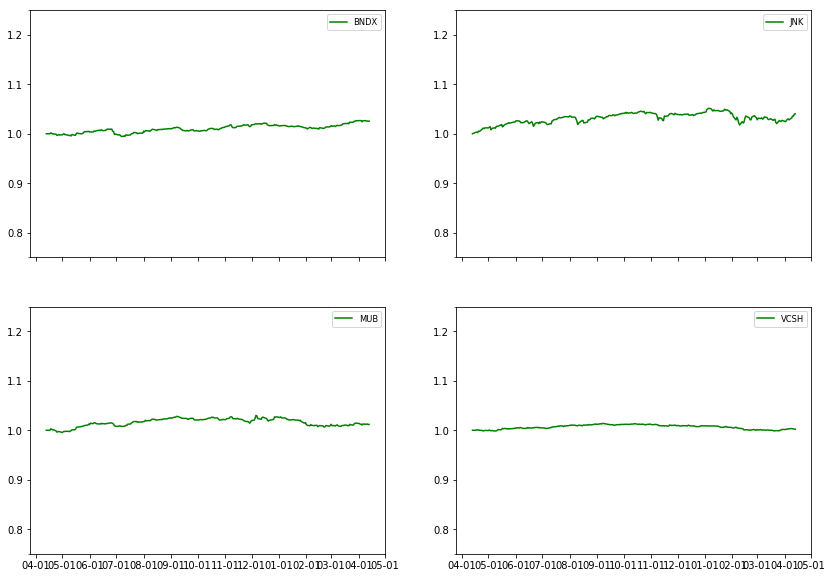

In [133]:
plot_chart_grid(consol_px, recommend, 'Allocation', opt_env.lookback, tickers, cols=int(len(alloc)/2))

In [134]:
daily_rets = consol_px[alloc.index].pct_change().fillna(0)
daily_rets.corr().mean().mean()

0.42556192499649864

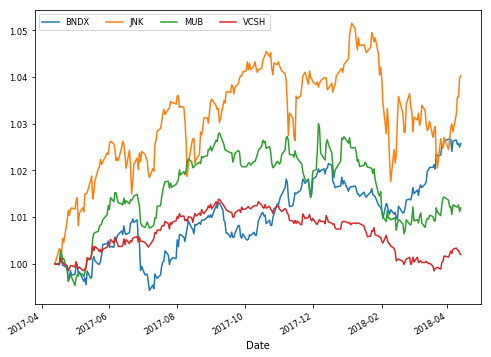

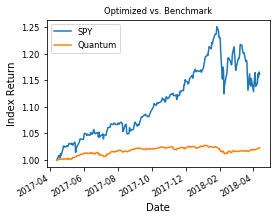

In [135]:
port_pos_idx = compound(consol_px[-opt_env.lookback:][recommend.index])
ax = port_pos_idx.plot(fontsize='small', figsize=(8,6))
ax.legend(fontsize='small', ncol=4)
idx_px_spy = compound(px_spy.loc[port_pos_idx.index])
plot_two_series(idx_px_spy, pdf, 'SPY', 'Quantum', 'Date', 'Index Return', 'Optimized vs. Benchmark')

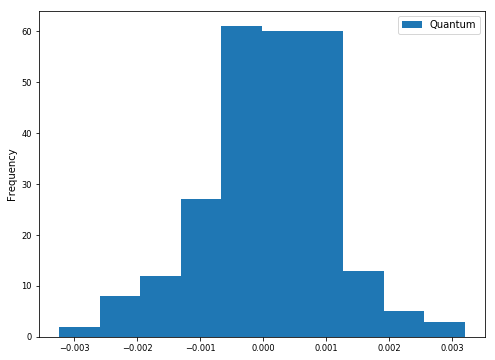

In [136]:
pdf.pct_change().plot(kind='hist', figsize=(8,6), fontsize='small')

In [137]:
# Outputs for trade execution
trading_df = get_sector_trading(220000, consol_px, tickers, opt_env.lookback, alloc)
pprint.pprint(summary_stats(consol_px, tickers, opt_env.lookback, alloc, recommend, trading_df))
if opt_env.refreshPricing: opt_env.save_recommendation(trading_df)    
trading_df

{'Date': '2018-04-13',
 'Long': 4,
 'Long Exposure': 0.9999998078630695,
 'Net Dollar Exposure': 219997,
 'Positions': 4,
 'Return (Ann)': 0.022922483182351287,
 'Risk (Vol)': 0.016174030965905896,
 'Sharpe Ratio': 1.417239971326308,
 'Short': 0,
 'Short Exposure': 0.0,
 'Total Allocation': 99.99998078630695}
Saved portfolio rebalance: ./recommendations/portrec_fixed-income_2018-04-14_21-57.csv


,Price,Allocation,Dollar Value,Shares
BNDX,54.650002,0.300000,65999,1207
JNK,36.160000,0.300000,65999,1825
MUB,108.470001,0.227997,50159,462
VCSH,78.269997,0.172003,37840,483
